In general we are trying to solve an overdetermined system of equations, $\text{A}\bf{x} = \bf{b}$.

 - Each row in the matrix $\text{A}$ is derived from ratios of redundant visiblities, such that the elements of $\text{A}$ are integers representing the antennas used in that ratio

 - the vector $\bf{b}$ contains the sum of the antenna cable delays for that visibility ratio

 - the solution $\bf{x}$ will provide the cable delay $\tau$ for each antenna

\begin{equation}
\begin{bmatrix} 
1 & -2 & 1 & 0 & 0 & 0 & 0 & \cdots& \cdots\\ 
1 & -1 & -1 & 1 & 0 & 0 & 0 & \cdots& \cdots\\ 
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots& \cdots\\ 
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots& \ddots\\ 
\end{bmatrix}
\begin{bmatrix} 
\tau_1 \\ \tau_2 \\ \tau_3 \\ \tau_4 \\ \tau_5 \\ \vdots \\ \vdots \\ \vdots\\
\end{bmatrix} =
\begin{bmatrix} 
134\text{ns} \\ 78\text{ns} \\ \vdots \\ \vdots \\ \vdots \\ \vdots \\ \vdots \\ \vdots\\
\end{bmatrix} \rightarrow \text{A}\bf{x} = \bf{b}
\end{equation}

Each visibility ratio is proportional to a complex exponential
\begin{equation}
\frac{V_{i j}}{V_{k l}} \propto \exp{\bigg(-2\pi i \cdot(\tau_i - \tau_j - \tau_k + \tau_l)\bigg)}
\end{equation}

Where in the example the first and second rows of $\text{A}$ are made from these visibilities:
\begin{align}
\frac{V_{12}}{V_{23}} &\leadsto 1\tau_1 -2\tau_2  + 1\tau_3 \rightarrow A_1\\
\frac{V_{12}}{V_{34}} &\leadsto 1\tau_1 -1\tau_2  - 1\tau_3 + 1\tau_4 \rightarrow A_2\\
\end{align} 

***


In [1]:
import sys, os
import random
import numpy as np

sys.path.insert(1, os.path.join(sys.path[0], '../../data_creation/'))
import data_manipulation as dm

import estdel

Load (or generate) a list of redundant baselines and get their data

In [2]:
red_bls, gains, uvd = dm.load_relevant_data('../../zen_data/zen.2458098.58037.xx.HH.uv',
                                            '../../zen_data/zen.2458098.58037.xx.HH.uv.abs.calfits')

In [3]:
_, _bl_dict = dm.get_or_gen_test_train_red_bls_dicts(red_bls, gains.keys(),
                                                     training_load_path = '../../data/training_redundant_baselines_dict_80.npz',
                                                     testing_load_path = '../../data/testing_redundant_baselines_dict_80.npz')
_bl_data = dm.get_seps_data(_bl_dict, uvd)

In [4]:
_bl_data = _bl_data
_bl_data_c = {key : _bl_data[key].conjugate() for key in _bl_data.keys()}

In [5]:
_gains = gains
_gains_c = {key : _gains[key].conjugate() for key in _gains.keys()}

***

Get the unique antennas

In [6]:
unique_ants = []
for key in _bl_dict.keys():
    if len(_bl_dict[key]) >= 2:
        for sep in _bl_dict[key]:
            for ant in sep:
                if ant not in unique_ants:
                    unique_ants.append(ant)

In [7]:
unique_ants = sorted(unique_ants)

Assign each antenna a random delay in the range of -100ns to 100ns

In [8]:
generated_ant_delays = {ant : np.random.uniform(low = -0.0100, high = 0.0100) for ant in unique_ants}

Generate a list of abstracted visibility ratios from redundant baselines ( pairs of redundant separations)

In [10]:
num_V_ratios = 100
list_o_sep_pairs = []

for i in range(num_V_ratios):
    
    # Randomly select a redundant baseline
    unique_baseline = random.sample(_bl_dict.keys(), 1)[0]
    
    while len(_bl_dict[unique_baseline]) < 2:
        unique_baseline = random.sample(_bl_dict.keys(), 1)[0]

    # randomly select two sepearations from that baseline
    two_seps = [random.sample(_bl_dict[unique_baseline], 2)][0]
    
    list_o_sep_pairs.append(two_seps)

***
Construct Data

In [11]:
def _flatness(seps):
    """Create a flatness from a given pair of seperations, their data & their gains."""

    a, b = seps[0][0], seps[0][1]
    c, d = seps[1][0], seps[1][1]

    return _bl_data[seps[0]]   * _gains_c[(a,'x')] * _gains[(b,'x')] * \
           _bl_data_c[seps[1]] * _gains[(c,'x')]   * _gains_c[(d,'x')]

In [12]:
def get_target(two_seps, d):
    
    ants = flatten_list_o_tuples(two_seps)
    
    ratio_delay  = d[ants[0]]
    ratio_delay -= d[ants[1]]
    ratio_delay -= d[ants[2]]
    ratio_delay += d[ants[3]]
    
    return ratio_delay

In [13]:
inputs = []
targets = []
flatten_list_o_tuples = lambda x: np.array(list(sum(x, ())))

nu = np.arange(1024)
for i in range(num_V_ratios):
    

    two_seps = list_o_sep_pairs[i]       
    true_delay = get_target(two_seps, generated_ant_delays)
    v_ratio = _flatness(two_seps)*np.exp(-2j*np.pi*(nu*true_delay + np.random.uniform()))
    
    inputs.append(v_ratio)
 

In [14]:
# delays in nanoseconds
true_ant_delays = {ant : estdel._100MHz_1024_channels(generated_ant_delays[ant]) for ant in generated_ant_delays.keys()}

In [15]:
%%time
tester = estdel.Antenna_Delay_Solver(list_o_sep_pairs, inputs, conversion_fn='default',true_ant_delays=true_ant_delays)

CPU times: user 2min 47s, sys: 38.8 s, total: 3min 26s
Wall time: 1min 16s


In [16]:
true_b = tester.true_b()

In [17]:
pred_b = tester.v_ratio_row_predictions

In [18]:
# http://maxwell.ucsc.edu/~drip/133/ch4.pdf
red_chi2 = np.sum((pred_b - np.mean(pred_b))**2/np.std(pred_b)**2) / len(pred_b)

In [19]:
red_chi2

1.0

In [20]:
import matplotlib.pyplot as plt

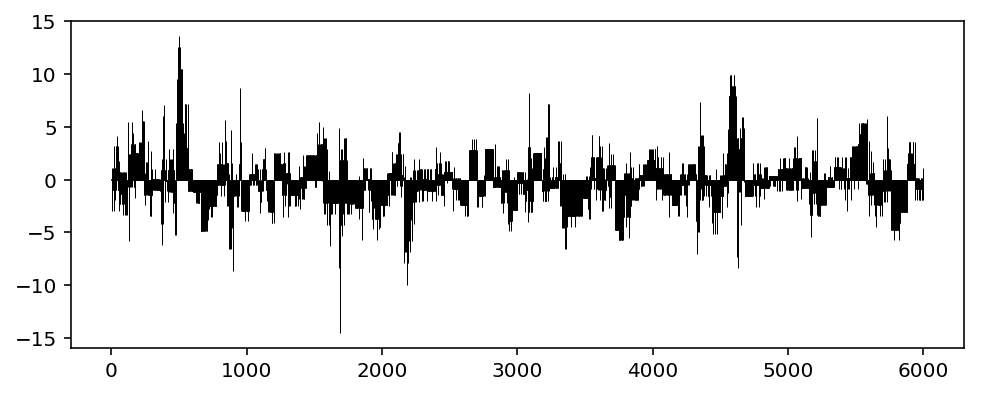

In [27]:
fig, ax = plt.subplots(figsize = (8,3), dpi = 144)
plt.vlines(range(len(pred_b)), 0, true_b- pred_b, lw = 0.5)

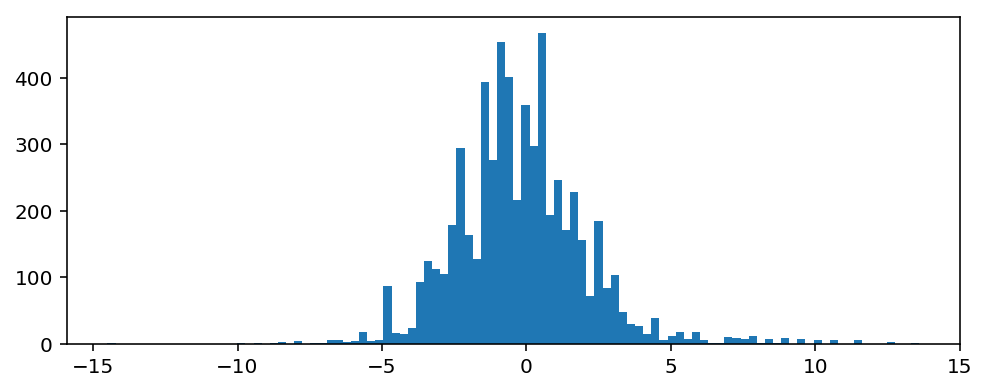

In [30]:
fig, ax = plt.subplots(figsize = (8,3), dpi = 144)
plt.hist(true_b- pred_b, bins = 100);

In [31]:
np.std(np.abs(true_b- pred_b))

1.5329085642510658